In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:45353 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [3]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

13.916031837463379


# Prepare data for processing

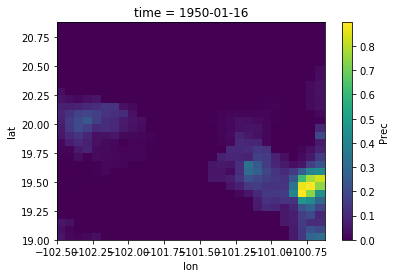

In [28]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(70,100), lon=slice(360,390), time=slice(0,60))
#ds2 = ds.isel(time=slice(0,60))
ds2.Prec.isel(time=0).load()
ds2.Prec.isel(time=0).plot()

In [48]:
#Set the number of bins we want to have for our data
bin_number = 2**9

In [30]:
#Stack the data along the space time axis
ds3 = ds2.stack(points=['lon','lat','time'])

# Quantize the data

In [31]:
#Shape the data
shape = da.stack([ds3.Prec.data, ds3.Tmax.data, ds3.Tmin.data])
shape = da.transpose(shape)
shape

dask.array<transpose, shape=(54000, 3), dtype=float32, chunksize=(1800, 1)>

In [49]:
#Build the histogram
H = np.histogramdd(shape, bins=bin_number)
data_quant = H[0]

# Compute DWT

In [50]:
#Set the number of levels for DWT, as well as the wavelet
levels = 1
wave = 'bior2.2'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = bin_number , filter_len = pywt.Wavelet(wave).dec_len) 

In [51]:
#Perform dwt on quantized data.
wp = pywt.wavedecn(data=data_quant, wavelet=wave, level = min(levels,max_level))
#wp = pywt.dwtn(data=data_quant, wavelet=wave)

In [47]:
#View the distribution of the DWT values
np.histogram(wp[0], bins=100)

(array([      1,       0,       2,       6,      11,      17,      41,
            110,     500,    5167, 2142445,   27256,   10768,    2848,
           3138,    1303,     734,     475,     334,     237,     192,
            155,     116,     110,     110,      68,      61,      59,
             59,      50,      47,      47,      36,      41,      34,
             28,      27,      26,      24,      22,      18,      22,
             19,      19,      14,      20,      20,      10,       8,
              9,      11,      14,      11,       7,       6,       0,
              8,       7,       7,       7,       6,       5,       2,
              9,       5,       2,       1,       5,       1,       1,
              0,       2,       0,       1,       3,       0,       1,
              4,       1,       2,       1,       0,       2,       0,
              1,       1,       0,       0,       0,       0,       1,
              0,       0,       0,       0,       0,       0,       0,
      

# Threshold the results of DWT

In [186]:
#Pick a threshold value.  
# For climate data, we probably only want the approximate (low frequency) coefficents to cluster. 
epsilon = .0001

In [187]:
#Threshold the DWT
wp[0][abs(wp[0])<epsilon] = 0
wp[0][abs(wp[0])>=epsilon] = 1

# Find connected components

In [188]:
#Compute the connected components of each thresholed DWT.  Adjacnecy is determined by ``four'' connectivity.
component = ndimage.label(wp[0])[0]

In [193]:
#Check number of connected components
np.max(wp[0])

1.0

# Create lookup Table

In [168]:
#The following lookup table is only built to handle the Haar wavelet.
#First, label data_quant classes
classes = np.repeat(component, levels + 1)

if data_quant.size % 2 ==1:  #If odd number of elements in array, need to deal with right endpoint
    classes = classes[:-1]

In [170]:
classes.shape

(4194304,)